## Filter performances


In [28]:
from pathlib import Path
import pandas as pd


import matplotlib.pyplot as plt

In [29]:
data_name = "DS03"
data_split = "test"
experiment_dir = Path('experiments')/data_name

## Import training data


In [30]:
df_hi = pd.read_csv(experiment_dir/f'hidata_{data_split}.csv')
units = df_hi['unit'].astype(int).unique().tolist()
units 

[10, 11, 12, 13, 14, 15]

In [31]:
df_hi

,unit,cycle,T48,SmLPC,SmHPC,hs
0,10.0,1.0,1.000000,0.753339,1.000000,1.0
1,10.0,2.0,1.000000,0.882929,0.986012,1.0
2,10.0,3.0,1.000000,0.795391,0.956751,1.0
3,10.0,4.0,1.000000,0.759443,0.974315,1.0
4,10.0,5.0,1.000000,0.913255,0.960047,1.0
...,...,...,...,...,...,...
433,15.0,63.0,0.185519,0.351799,0.280634,0.0
434,15.0,64.0,0.126497,0.226653,0.143133,0.0
435,15.0,65.0,0.082829,0.279501,0.099981,0.0
436,15.0,66.0,0.000000,0.214309,0.002182,0.0


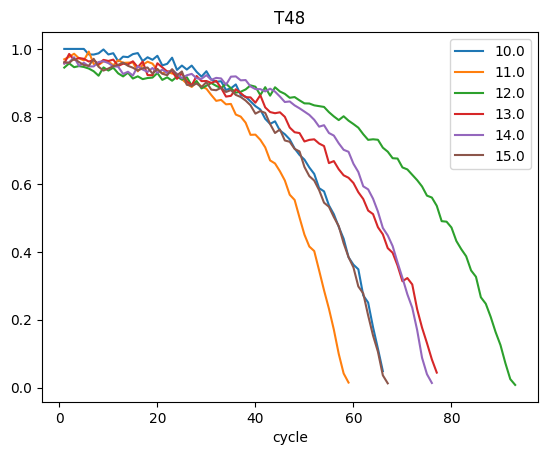

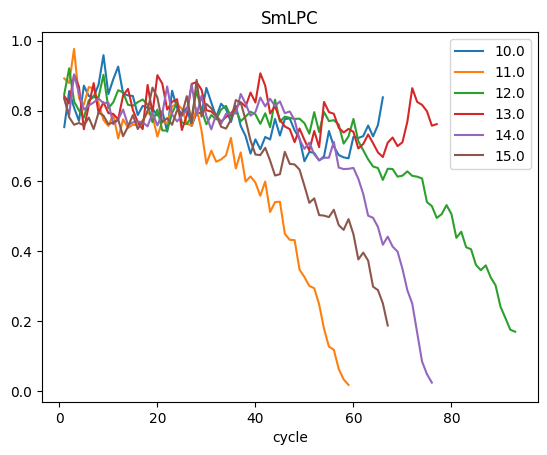

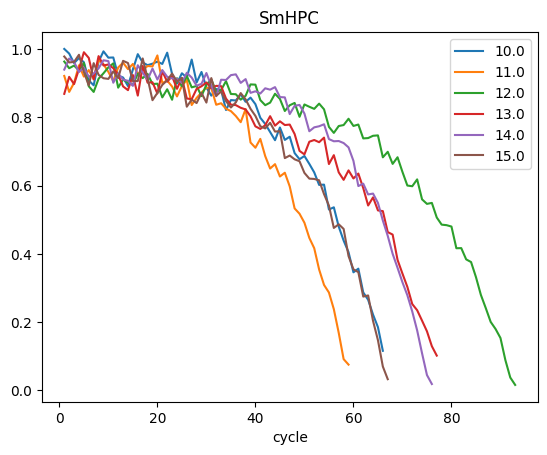

In [37]:
perform_names = [col for col in df_hi.columns if col not in ['unit', 'cycle','hs']]
for name in perform_names:
    fig, ax = plt.subplots()
    ax.title.set_text(name)
    df_hi.set_index("cycle").groupby("unit")[name].plot(legend=True) 
    

In [33]:
class AdaptiveEMA:
    def __init__(self, beta=0.05, k=10.0):
        self.beta = beta      # noise memory
        self.k = k            # smoothing strength
        self.y = None
        self.var = 0.0

    def step(self, x):
        if self.y is None:
            self.y = x
            return x

        # innovation
        e = x - self.y

        # update noise estimate (EW variance)
        self.var = self.beta * (e ** 2) + (1 - self.beta) * self.var
        sigma = self.var ** 0.5

        # adaptive smoothing
        alpha = 1.0 / (1.0 + self.k * sigma)

        # update filtered signal
        self.y = alpha * x + (1 - alpha) * self.y

        return self.y

In [34]:
noise_memory = 0.01
smoothing_strength = 20.0
for name in perform_names:
	for unit, idx in df_hi.groupby("unit").groups.items():
		f = AdaptiveEMA(beta=noise_memory, k=smoothing_strength)
		df_hi.loc[idx, name] = [
			f.step(x) for x in df_hi.loc[idx, name].values
		]

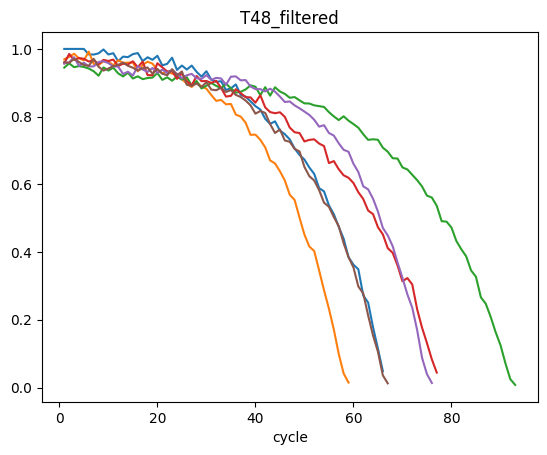

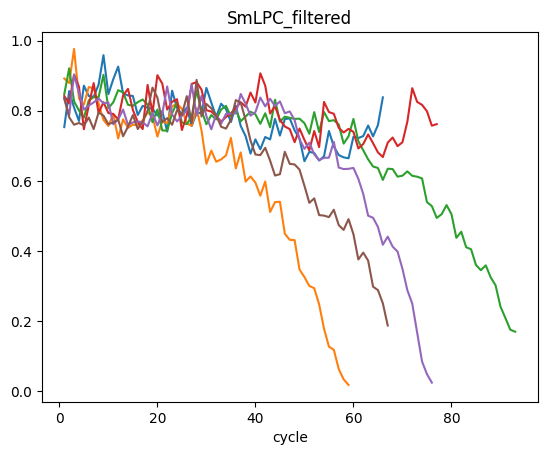

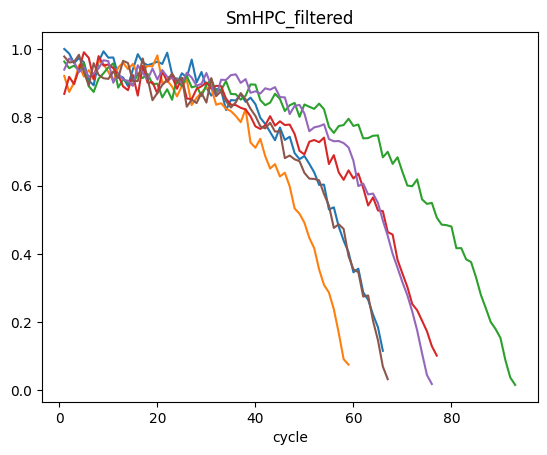

In [35]:
for name in perform_names:
    fig, ax = plt.subplots()
    ax.title.set_text(f"{name}_filtered")
    df_hi.set_index("cycle").groupby("unit")[name].plot(legend=False)
    plt.show()

## Save filtered hi data

In [36]:
df_hi.to_csv(experiment_dir/f'hidata_{data_split}_filtered.csv', index=False)